In [16]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from joblib import dump
import ast  # para converter string em lista de tuplas
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier


In [48]:
df_bruno = pd.read_csv("../scrub/tabelas_pessoa_pos_tratamento/bruno.csv")
df_erik = pd.read_csv("../scrub/tabelas_pessoa_pos_tratamento/erik.csv")
df_felipe = pd.read_csv("../scrub/tabelas_pessoa_pos_tratamento/felipe.csv")
df_guilherme = pd.read_csv("../scrub/tabelas_pessoa_pos_tratamento/guilherme.csv")
df_jao = pd.read_csv("../scrub/tabelas_pessoa_pos_tratamento/jao.csv")
df_jose = pd.read_csv("../scrub/tabelas_pessoa_pos_tratamento/jose.csv")
df_lo = pd.read_csv("../scrub/tabelas_pessoa_pos_tratamento/lo.csv")

In [49]:
# Lista de dataframes
dfs = [
    df_bruno, df_erik, df_felipe, df_guilherme, df_jao, df_jose, df_lo
]

# Normaliza coluna "piscando" para 0 e 1
for i in dfs:
    i["piscando"] = i["piscando"].map({False: 0, True: 1})

def safe_eval(val):
    if isinstance(val, str):
        try:
            return ast.literal_eval(val)
        except Exception:
            return []
    elif isinstance(val, (list, tuple)):
        return val
    else:
        return []

for df in dfs:
    for col in pontos_cols:
        df[col] = df[col].apply(safe_eval)
        df[[f"{col}_x{j}" for j in range(19)]] = pd.DataFrame(
            df[col].apply(lambda pts: [p[0] for p in pts[:19]] + [None]*(19-len(pts))).tolist()
        )
        df[[f"{col}_y{j}" for j in range(19)]] = pd.DataFrame(
            df[col].apply(lambda pts: [p[1] for p in pts[:19]] + [None]*(19-len(pts))).tolist()
        )


/tmp/ipykernel_14975/1382834809.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[[f"{col}_x{j}" for j in range(19)]] = pd.DataFrame(
/tmp/ipykernel_14975/1382834809.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[[f"{col}_x{j}" for j in range(19)]] = pd.DataFrame(
/tmp/ipykernel_14975/1382834809.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead

In [50]:
cm_total = np.zeros((2,2))

for idx, df_test in enumerate(dfs):
    df_train = pd.concat([df for j, df in enumerate(dfs) if j != idx], ignore_index=True)

    X_train = df_train[["ear1","ear2","ear3","ear4","ear5"]]
    y_train = df_train["piscando"]

    X_test = df_test[["ear1","ear2","ear3","ear4","ear5"]]
    y_test = df_test["piscando"]

    model = DecisionTreeClassifier(random_state=42)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    cm = confusion_matrix(y_test, y_pred)
    cm_total += cm


In [52]:
## SOMENTE PONTOS

feature_cols = []
for col in pontos_cols:
    feature_cols += [f"{col}_x{j}" for j in range(19)] + [f"{col}_y{j}" for j in range(19)]

cm_total = np.zeros((2,2))

# Leave-one-subject-out
for idx, df_test in enumerate(dfs):
    df_train = pd.concat([df for j, df in enumerate(dfs) if j != idx], ignore_index=True)
    
    X_train = df_train[feature_cols]
    y_train = df_train["piscando"]
    
    X_test = df_test[feature_cols]
    y_test = df_test["piscando"]
    
    model = DecisionTreeClassifier(random_state=42)
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    
    cm = confusion_matrix(y_test, y_pred)
    cm_total += cm


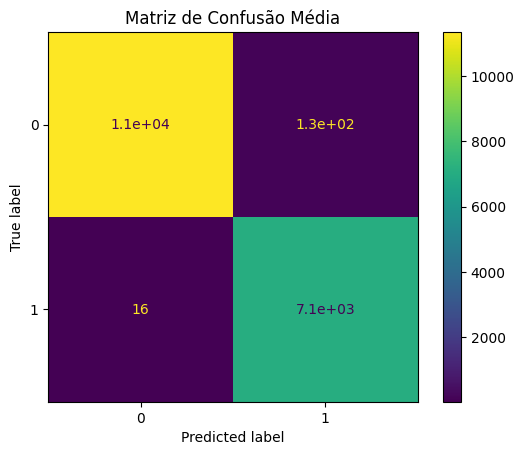

In [53]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm_total, display_labels=[0,1])
disp.plot()
plt.title("Matriz de Confusão Média")
plt.show()

In [54]:
def calculate_metrics_from_cm(cm, precision_digits=3):

    TN, FP, FN, TP = cm.ravel()

    accuracy = (TP + TN) / (TP + TN + FP + FN)
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0.0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0.0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0
    
    metrics = {
        "Acurácia": round(accuracy, precision_digits),
        "Precisão": round(precision, precision_digits),
        "Revocação": round(recall, precision_digits),
        "F1-Score": round(f1_score, precision_digits),
    }
    
    return metrics

print(calculate_metrics_from_cm(cm_total))

{'Acurácia': np.float64(0.992), 'Precisão': np.float64(0.982), 'Revocação': np.float64(0.998), 'F1-Score': np.float64(0.99)}
